<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/LR(Multinomial)(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 STARTING 3-CLASS AGRICULTURAL PRODUCTION CLASSIFICATION
🌾 Using Multinomial Logistic Regression
STEP 1: LOADING AND PREPROCESSING DATA
✓ Train data shape: (3584, 84)
✓ Validation data shape: (768, 84)
✓ Test data shape: (768, 84)
✓ Missing values handled successfully

STEP 2: CREATING 3-CLASS QUANTILE-BASED LABELS
✓ Quantile thresholds:
  - Low/Medium boundary: 1018.0000 M.Ton
  - Medium/High boundary: 3979.0000 M.Ton

✓ Label distribution in training set:
  - Low: 1184 samples (33.0%)
  - Medium: 1218 samples (34.0%)
  - High: 1182 samples (33.0%)

✓ Label distribution in validation set:
  - Low: 247 samples (32.2%)
  - Medium: 264 samples (34.4%)
  - High: 257 samples (33.5%)

✓ Label distribution in test set:
  - Low: 252 samples (32.8%)
  - Medium: 268 samples (34.9%)
  - High: 248 samples (32.3%)

STEP 3: PREPARING FEATURES
✓ Number of features: 83
✓ Feature columns identified: 83 features
✓ Scaling features using StandardScaler...
✓ Training features shape: (3584, 83)
✓ Validat

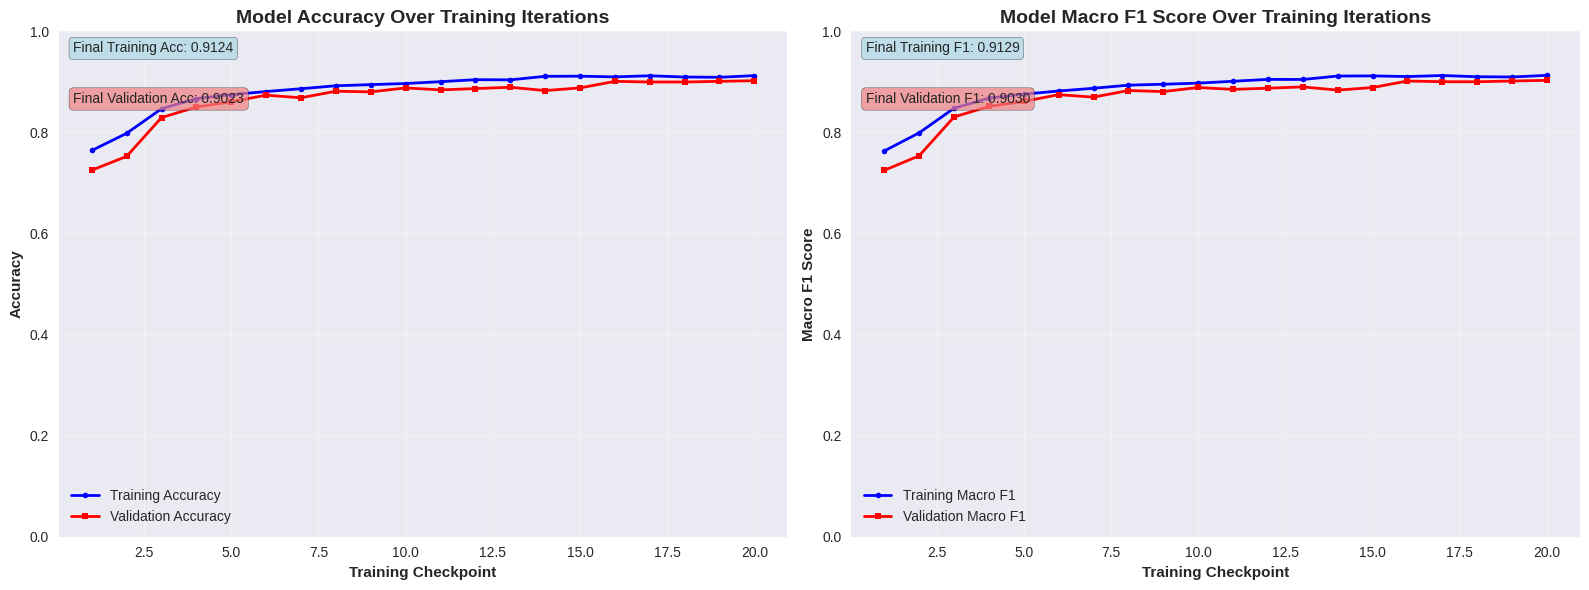

✓ Training history plots generated!

GENERATING CONFUSION MATRICES


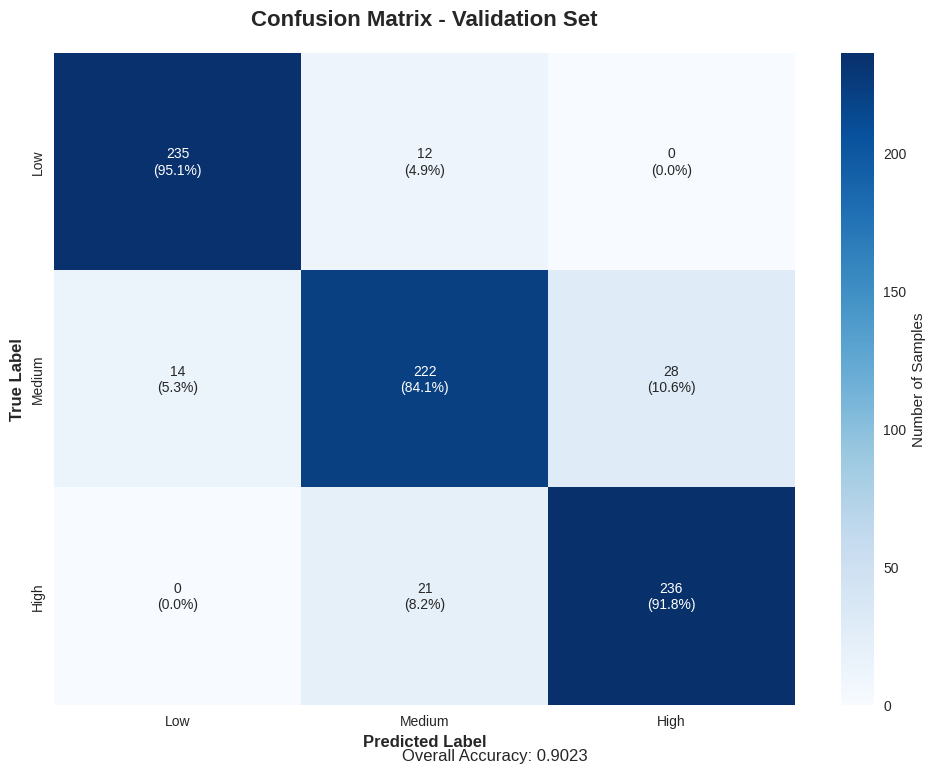

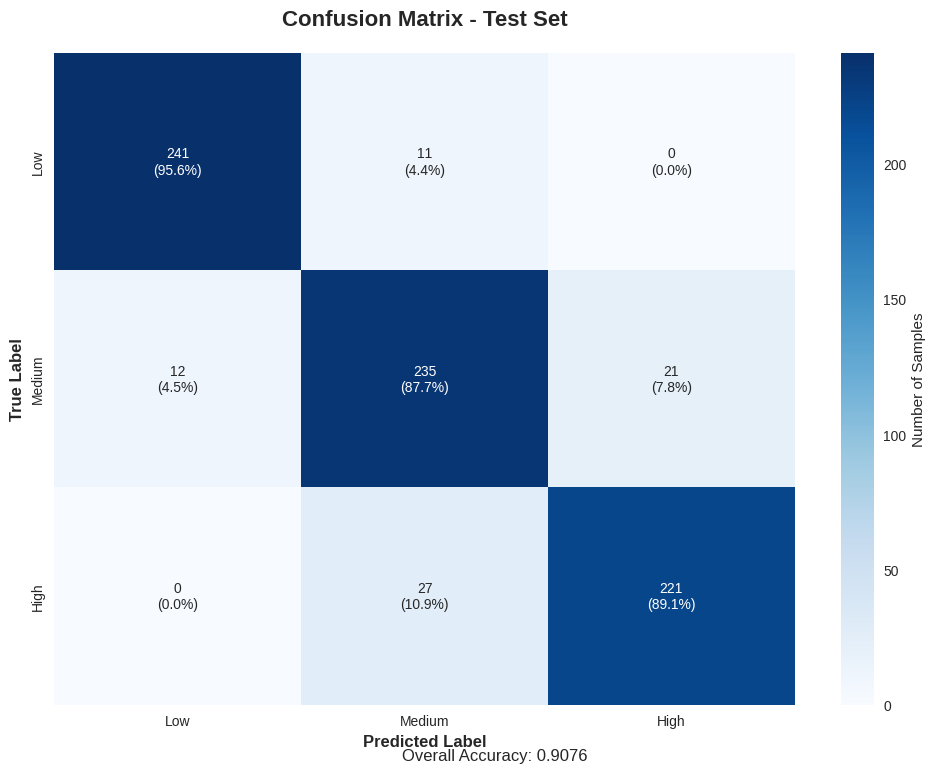


STEP 7: COMPREHENSIVE METRICS SUMMARY
📊 CLASSIFICATION METRICS COMPARISON
------------------------------------------------------------
                      Validation Set  Test Set
Accuracy                      0.9023    0.9076
Precision (Weighted)          0.9019    0.9078
Precision (Macro)             0.9028    0.9089
Recall (Weighted)             0.9023    0.9076
Recall (Macro)                0.9035    0.9081
F1 Score (Weighted)           0.9020    0.9076
F1 Score (Macro)              0.9030    0.9084

📊 PER-CLASS METRICS COMPARISON
------------------------------------------------------------
           Low - Validation  Medium - Validation  High - Validation  \
Precision            0.9438               0.8706             0.8939   
Recall               0.9514               0.8409             0.9183   
F1 Score             0.9476               0.8555             0.9060   

           Low - Test  Medium - Test  High - Test  
Precision      0.9526         0.8608       0.9132  
Recall

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class ProductionClassifier3Class:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None
        self.label_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
        self.history = {'train_accuracy': [], 'val_accuracy': [], 'train_f1': [], 'val_f1': []}

    def load_and_preprocess_data(self, train_path, val_path, test_path):
        """Load and preprocess the datasets"""
        print("=" * 60)
        print("STEP 1: LOADING AND PREPROCESSING DATA")
        print("=" * 60)

        # Load datasets
        self.train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
        self.val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
        self.test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

        print(f"✓ Train data shape: {self.train_df.shape}")
        print(f"✓ Validation data shape: {self.val_df.shape}")
        print(f"✓ Test data shape: {self.test_df.shape}")

        # Handle missing values
        for df in [self.train_df, self.val_df, self.test_df]:
            df.fillna(df.mean(numeric_only=True), inplace=True)

        print("✓ Missing values handled successfully")
        return self.train_df, self.val_df, self.test_df

    def create_quantile_labels(self):
        """Create 3-class quantile-based labels for production"""
        print("\n" + "=" * 60)
        print("STEP 2: CREATING 3-CLASS QUANTILE-BASED LABELS")
        print("=" * 60)

        # Calculate quantiles from training data (33rd and 67th percentiles for 3 classes)
        production_col = 'Production (M.Ton)'
        quantiles = self.train_df[production_col].quantile([0.33, 0.67]).values

        print(f"✓ Quantile thresholds:")
        print(f"  - Low/Medium boundary: {quantiles[0]:.4f} M.Ton")
        print(f"  - Medium/High boundary: {quantiles[1]:.4f} M.Ton")

        def assign_label(value):
            if value <= quantiles[0]:
                return 0  # Low
            elif value <= quantiles[1]:
                return 1  # Medium
            else:
                return 2  # High

        # Apply labels to all datasets
        self.y_train = self.train_df[production_col].apply(assign_label)
        self.y_val = self.val_df[production_col].apply(assign_label)
        self.y_test = self.test_df[production_col].apply(assign_label)

        # Print label distribution
        print("\n✓ Label distribution in training set:")
        for i, label in self.label_mapping.items():
            count = (self.y_train == i).sum()
            print(f"  - {label}: {count} samples ({count/len(self.y_train)*100:.1f}%)")

        print("\n✓ Label distribution in validation set:")
        for i, label in self.label_mapping.items():
            count = (self.y_val == i).sum()
            print(f"  - {label}: {count} samples ({count/len(self.y_val)*100:.1f}%)")

        print("\n✓ Label distribution in test set:")
        for i, label in self.label_mapping.items():
            count = (self.y_test == i).sum()
            print(f"  - {label}: {count} samples ({count/len(self.y_test)*100:.1f}%)")

    def prepare_features(self):
        """Prepare feature matrices"""
        print("\n" + "=" * 60)
        print("STEP 3: PREPARING FEATURES")
        print("=" * 60)

        # Remove target column and prepare features
        feature_cols = [col for col in self.train_df.columns if col != 'Production (M.Ton)']

        self.X_train = self.train_df[feature_cols]
        self.X_val = self.val_df[feature_cols]
        self.X_test = self.test_df[feature_cols]

        print(f"✓ Number of features: {len(feature_cols)}")
        print(f"✓ Feature columns identified: {len(feature_cols)} features")

        # Scale features
        print("✓ Scaling features using StandardScaler...")
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        print(f"✓ Training features shape: {self.X_train_scaled.shape}")
        print(f"✓ Validation features shape: {self.X_val_scaled.shape}")
        print(f"✓ Test features shape: {self.X_test_scaled.shape}")

    def train_model(self, epochs=100, C=250):
        """Train the multinomial logistic regression model"""
        print("\n" + "=" * 60)
        print(f"STEP 4: TRAINING MULTINOMIAL LOGISTIC REGRESSION")
        print("=" * 60)
        print(f"✓ Training for {epochs} iterations with C={C}")

        # Initialize model
        self.model = LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',
            C=C,
            max_iter=epochs,
            random_state=42
        )

        # Train model
        self.model.fit(self.X_train_scaled, self.y_train)
        print("✓ Model training completed!")

        # Calculate training and validation metrics for each iteration
        # We'll simulate this by training models with increasing max_iter
        epoch_steps = max(1, epochs // 20)  # 20 evaluation points
        eval_points = range(epoch_steps, epochs + 1, epoch_steps)

        print(f"✓ Evaluating model performance at {len(eval_points)} checkpoints...")

        for i, max_iter in enumerate(eval_points):
            temp_model = LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                C=C,
                max_iter=max_iter,
                random_state=42
            )
            temp_model.fit(self.X_train_scaled, self.y_train)

            # Training metrics
            train_pred = temp_model.predict(self.X_train_scaled)
            train_acc = accuracy_score(self.y_train, train_pred)
            train_f1 = f1_score(self.y_train, train_pred, average='macro')

            # Validation metrics
            val_pred = temp_model.predict(self.X_val_scaled)
            val_acc = accuracy_score(self.y_val, val_pred)
            val_f1 = f1_score(self.y_val, val_pred, average='macro')

            self.history['train_accuracy'].append(train_acc)
            self.history['val_accuracy'].append(val_acc)
            self.history['train_f1'].append(train_f1)
            self.history['val_f1'].append(val_f1)

            if (i + 1) % 5 == 0:
                print(f"  Checkpoint {i+1}/{len(eval_points)}: Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

        print("✓ Training history recorded!")

    def evaluate_model(self, X, y, dataset_name):
        """Evaluate model and return comprehensive metrics"""
        print(f"\n{'='*60}")
        print(f"STEP 5: EVALUATING MODEL ON {dataset_name.upper()} SET")
        print(f"{'='*60}")

        predictions = self.model.predict(X)

        # Calculate all metrics
        accuracy = accuracy_score(y, predictions)
        precision_weighted = precision_score(y, predictions, average='weighted')
        precision_macro = precision_score(y, predictions, average='macro')
        recall_weighted = recall_score(y, predictions, average='weighted')
        recall_macro = recall_score(y, predictions, average='macro')
        f1_weighted = f1_score(y, predictions, average='weighted')
        f1_macro = f1_score(y, predictions, average='macro')

        # Per-class metrics
        precision_per_class = precision_score(y, predictions, average=None)
        recall_per_class = recall_score(y, predictions, average=None)
        f1_per_class = f1_score(y, predictions, average=None)

        # Classification report
        report = classification_report(
            y, predictions,
            target_names=list(self.label_mapping.values()),
            output_dict=True
        )

        print(f"✓ {dataset_name} Classification Results:")
        print(f"  📊 Accuracy: {accuracy:.4f}")
        print(f"  📊 Precision (Weighted): {precision_weighted:.4f}")
        print(f"  📊 Precision (Macro): {precision_macro:.4f}")
        print(f"  📊 Recall (Weighted): {recall_weighted:.4f}")
        print(f"  📊 Recall (Macro): {recall_macro:.4f}")
        print(f"  📊 F1 Score (Weighted): {f1_weighted:.4f}")
        print(f"  📊 F1 Score (Macro): {f1_macro:.4f}")

        print(f"\n✓ Per-Class Metrics:")
        for i, label in self.label_mapping.items():
            print(f"  - {label}: Precision={precision_per_class[i]:.4f}, "
                  f"Recall={recall_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}")

        return {
            'accuracy': accuracy,
            'precision_weighted': precision_weighted,
            'precision_macro': precision_macro,
            'recall_weighted': recall_weighted,
            'recall_macro': recall_macro,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'predictions': predictions,
            'report': report,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'f1_per_class': f1_per_class
        }

    def plot_confusion_matrix(self, y_true, y_pred, dataset_name):
        """Plot confusion matrix with enhanced styling"""
        cm = confusion_matrix(y_true, y_pred)

        # Calculate percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        plt.figure(figsize=(10, 8))

        # Create annotations with both counts and percentages
        annotations = []
        for i in range(cm.shape[0]):
            row = []
            for j in range(cm.shape[1]):
                row.append(f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)')
            annotations.append(row)

        sns.heatmap(
            cm,
            annot=annotations,
            fmt='',
            cmap='Blues',
            xticklabels=list(self.label_mapping.values()),
            yticklabels=list(self.label_mapping.values()),
            cbar_kws={'label': 'Number of Samples'}
        )

        plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
        plt.ylabel('True Label', fontsize=12, fontweight='bold')

        # Add accuracy as subtitle
        accuracy = accuracy_score(y_true, y_pred)
        plt.suptitle(f'Overall Accuracy: {accuracy:.4f}', fontsize=12, y=0.02)

        plt.tight_layout()
        plt.show()

    def plot_training_history(self):
        """Plot training vs validation accuracy and F1 score"""
        print(f"\n{'='*60}")
        print("STEP 6: PLOTTING TRAINING HISTORY")
        print(f"{'='*60}")

        epochs = range(1, len(self.history['train_accuracy']) + 1)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Accuracy plot
        ax1.plot(epochs, self.history['train_accuracy'], 'b-o',
                label='Training Accuracy', linewidth=2, markersize=4)
        ax1.plot(epochs, self.history['val_accuracy'], 'r-s',
                label='Validation Accuracy', linewidth=2, markersize=4)
        ax1.set_title('Model Accuracy Over Training Iterations', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Training Checkpoint', fontweight='bold')
        ax1.set_ylabel('Accuracy', fontweight='bold')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim([0, 1])

        # Add final accuracy values as text
        final_train_acc = self.history['train_accuracy'][-1]
        final_val_acc = self.history['val_accuracy'][-1]
        ax1.text(0.02, 0.98, f'Final Training Acc: {final_train_acc:.4f}',
                transform=ax1.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        ax1.text(0.02, 0.88, f'Final Validation Acc: {final_val_acc:.4f}',
                transform=ax1.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

        # F1 Score plot
        ax2.plot(epochs, self.history['train_f1'], 'b-o',
                label='Training Macro F1', linewidth=2, markersize=4)
        ax2.plot(epochs, self.history['val_f1'], 'r-s',
                label='Validation Macro F1', linewidth=2, markersize=4)
        ax2.set_title('Model Macro F1 Score Over Training Iterations', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Training Checkpoint', fontweight='bold')
        ax2.set_ylabel('Macro F1 Score', fontweight='bold')
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([0, 1])

        # Add final F1 values as text
        final_train_f1 = self.history['train_f1'][-1]
        final_val_f1 = self.history['val_f1'][-1]
        ax2.text(0.02, 0.98, f'Final Training F1: {final_train_f1:.4f}',
                transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        ax2.text(0.02, 0.88, f'Final Validation F1: {final_val_f1:.4f}',
                transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

        plt.tight_layout()
        plt.show()
        print("✓ Training history plots generated!")

    def create_comprehensive_metrics_table(self, val_results, test_results):
        """Create a comprehensive summary table of all metrics"""
        print(f"\n{'='*60}")
        print("STEP 7: COMPREHENSIVE METRICS SUMMARY")
        print(f"{'='*60}")

        metrics_df = pd.DataFrame({
            'Validation Set': [
                val_results['accuracy'],
                val_results['precision_weighted'],
                val_results['precision_macro'],
                val_results['recall_weighted'],
                val_results['recall_macro'],
                val_results['f1_weighted'],
                val_results['f1_macro']
            ],
            'Test Set': [
                test_results['accuracy'],
                test_results['precision_weighted'],
                test_results['precision_macro'],
                test_results['recall_weighted'],
                test_results['recall_macro'],
                test_results['f1_weighted'],
                test_results['f1_macro']
            ]
        }, index=[
            'Accuracy',
            'Precision (Weighted)',
            'Precision (Macro)',
            'Recall (Weighted)',
            'Recall (Macro)',
            'F1 Score (Weighted)',
            'F1 Score (Macro)'
        ])

        print("📊 CLASSIFICATION METRICS COMPARISON")
        print("-" * 60)
        print(metrics_df.round(4))

        # Per-class metrics table
        class_metrics_df = pd.DataFrame({
            'Low - Validation': [
                val_results['precision_per_class'][0],
                val_results['recall_per_class'][0],
                val_results['f1_per_class'][0]
            ],
            'Medium - Validation': [
                val_results['precision_per_class'][1],
                val_results['recall_per_class'][1],
                val_results['f1_per_class'][1]
            ],
            'High - Validation': [
                val_results['precision_per_class'][2],
                val_results['recall_per_class'][2],
                val_results['f1_per_class'][2]
            ],
            'Low - Test': [
                test_results['precision_per_class'][0],
                test_results['recall_per_class'][0],
                test_results['f1_per_class'][0]
            ],
            'Medium - Test': [
                test_results['precision_per_class'][1],
                test_results['recall_per_class'][1],
                test_results['f1_per_class'][1]
            ],
            'High - Test': [
                test_results['precision_per_class'][2],
                test_results['recall_per_class'][2],
                test_results['f1_per_class'][2]
            ]
        }, index=['Precision', 'Recall', 'F1 Score'])

        print("\n📊 PER-CLASS METRICS COMPARISON")
        print("-" * 60)
        print(class_metrics_df.round(4))

        return metrics_df, class_metrics_df

# Main execution function
def main():
    """Execute the complete machine learning pipeline"""
    print("🚀 STARTING 3-CLASS AGRICULTURAL PRODUCTION CLASSIFICATION")
    print("🌾 Using Multinomial Logistic Regression")
    print("=" * 80)

    # Initialize classifier
    classifier = ProductionClassifier3Class()

    # Step 1: Load and preprocess data
    train_df, val_df, test_df = classifier.load_and_preprocess_data(
        '/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv', '/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv', '/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv'
    )

    # Step 2: Create 3-class quantile-based labels
    classifier.create_quantile_labels()

    # Step 3: Prepare features
    classifier.prepare_features()

    # Step 4: Train model
    classifier.train_model(epochs=100, C=250)

    # Step 5: Evaluate on both validation and test sets
    val_results = classifier.evaluate_model(
        classifier.X_val_scaled, classifier.y_val, "Validation"
    )

    test_results = classifier.evaluate_model(
        classifier.X_test_scaled, classifier.y_test, "Test"
    )

    # Step 6: Plot training history
    classifier.plot_training_history()

    # Step 7: Plot confusion matrices
    print(f"\n{'='*60}")
    print("GENERATING CONFUSION MATRICES")
    print(f"{'='*60}")

    classifier.plot_confusion_matrix(
        classifier.y_val, val_results['predictions'], "Validation Set"
    )

    classifier.plot_confusion_matrix(
        classifier.y_test, test_results['predictions'], "Test Set"
    )

    # Step 8: Create comprehensive metrics summary
    overall_metrics, class_metrics = classifier.create_comprehensive_metrics_table(
        val_results, test_results
    )

    # Final summary
    print(f"\n{'='*80}")
    print("🎉 MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
    print(f"{'='*80}")
    print(f"✅ Model Type: Multinomial Logistic Regression")
    print(f"✅ Classes: 3 (Low, Medium, High)")
    print(f"✅ Features: {classifier.X_train_scaled.shape[1]}")
    print(f"✅ Training Samples: {len(classifier.y_train)}")
    print(f"✅ Validation Samples: {len(classifier.y_val)}")
    print(f"✅ Test Samples: {len(classifier.y_test)}")
    print(f"✅ Final Validation Accuracy: {val_results['accuracy']:.4f}")
    print(f"✅ Final Test Accuracy: {test_results['accuracy']:.4f}")
    print(f"✅ Final Validation Macro F1: {val_results['f1_macro']:.4f}")
    print(f"✅ Final Test Macro F1: {test_results['f1_macro']:.4f}")
    print(f"{'='*80}")

    return classifier, val_results, test_results, overall_metrics, class_metrics

# Execute the complete pipeline
if __name__ == "__main__":
    classifier, val_results, test_results, overall_metrics, class_metrics = main()